In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_3dim100_NL.npz')                #LHS  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples:', len(train_params['omega_b'])) 
print(train_params['h'])

number of training samples: 100
[0.65616162 0.64646465 0.71272727 0.69171717 0.66262626 0.72080808
 0.78868687 0.72888889 0.71919192 0.74181818 0.78222222 0.7579798
 0.69656566 0.69818182 0.67393939 0.74343434 0.79676768 0.75636364
 0.79838384 0.79515152 0.7369697  0.67717172 0.71757576 0.65777778
 0.74020202 0.77252525 0.72565657 0.78060606 0.64969697 0.76282828
 0.73858586 0.70626263 0.70787879 0.64808081 0.68848485 0.6610101
 0.70949495 0.67232323 0.79191919 0.72242424 0.78707071 0.69010101
 0.65292929 0.65454545 0.69494949 0.6820202  0.64484848 0.76606061
 0.75313131 0.70464646 0.66747475 0.67878788 0.8        0.68686869
 0.65131313 0.74828283 0.77090909 0.66909091 0.64323232 0.68363636
 0.7789899  0.67070707 0.68525253 0.74989899 0.65939394 0.76767677
 0.73050505 0.75474747 0.79353535 0.70141414 0.76929293 0.76121212
 0.73535354 0.68040404 0.72727273 0.73212121 0.69333333 0.77737374
 0.64       0.73373737 0.77575758 0.64161616 0.78545455 0.66424242
 0.67555556 0.69979798 0.7030303

In [6]:
cosmo_params = np.zeros((len(train_params['h']), 3))
print(cosmo_params[4])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']

## Training input params:
h = cosmo_params[:, 0]
omega_b = cosmo_params[:, 1]
omega_c = cosmo_params[:, 2]

[0. 0. 0.]


In [8]:
with open('pk_data_3dim100_NL1.pkl', 'rb') as f, open('pk_data_3dim100_NL2.pkl', 'rb') as g:
    pk_matrix = pickle.load(f)
    pk_nonlin_matrix = pickle.load(g)

pk_matrix = np.asarray(pk_matrix).astype('float32')
pk_matrix.dtype

In [9]:
h.dtype

dtype('float64')

In [10]:
# Training input params and output param:

train_H0 = 100*h
train_omega_b = omega_b                       
train_omega_c = omega_c

train_pk = pk_matrix                    
train_pk_nonlin = pk_nonlin_matrix 
print("train_pk shape:", np.shape(train_pk))
print("train_pk_nonlin shape:", np.shape(train_pk_nonlin))
print(len(train_pk[4]))

train_pk shape: (100, 500)
train_pk_nonlin shape: (100, 500)
500


In [11]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c])                                        # 1x5000

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm']

output_data = pd.DataFrame(train_pk)
output_data_nonlin = pd.DataFrame(train_pk_nonlin)  
print(input_data)                                                         #5000x1
print(output_data)

(100, 3)
(100, 500)
           H0   Omega_b  Omega_cdm
0   65.616162  0.020899   0.223737
1   64.646465  0.024222   0.062121
2   71.272727  0.018707   0.050000
3   69.171717  0.019980   0.191414
4   66.262626  0.019202   0.128788
..        ...       ...        ...
95  76.444444  0.023869   0.054040
96  74.666667  0.019768   0.086364
97  79.030303  0.019131   0.148990
98  71.595960  0.020828   0.203535
99  71.111111  0.021889   0.205556

[100 rows x 3 columns]
            0            1            2            3            4    \
0     84.054216    86.016772    88.025136    90.080374    92.183577   
1   2101.978609  2151.011827  2201.186129  2252.527890  2305.064085   
2   4899.677986  5013.876792  5130.726267  5250.287085  5372.621274   
3    136.923689   140.120416   143.391735   146.739386   150.165150   
4    327.438040   335.081220   342.902636   350.906429   359.096837   
..          ...          ...          ...          ...          ...   
95  4911.308965  5025.796275  5142.9421

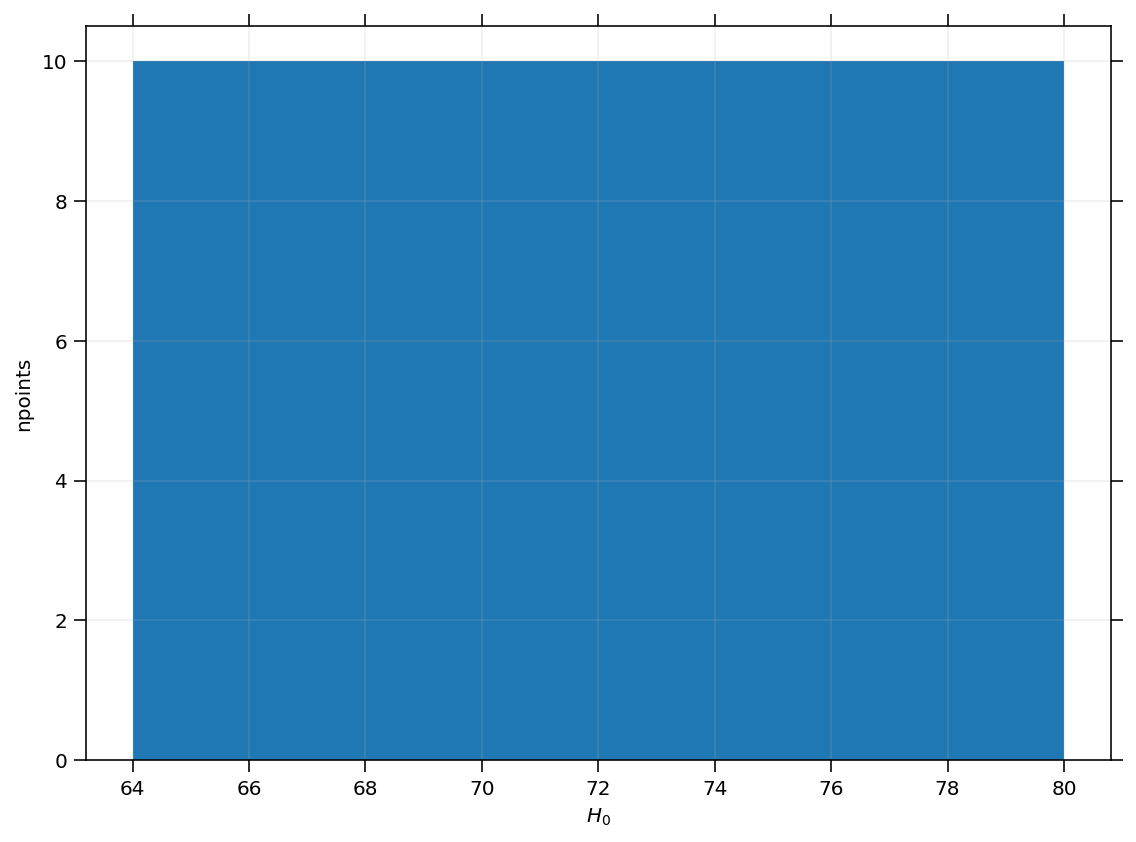

In [12]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])
#plt.hist(input_data['Omega_b'])
#plt.hist(input_data['Omega_cdm'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

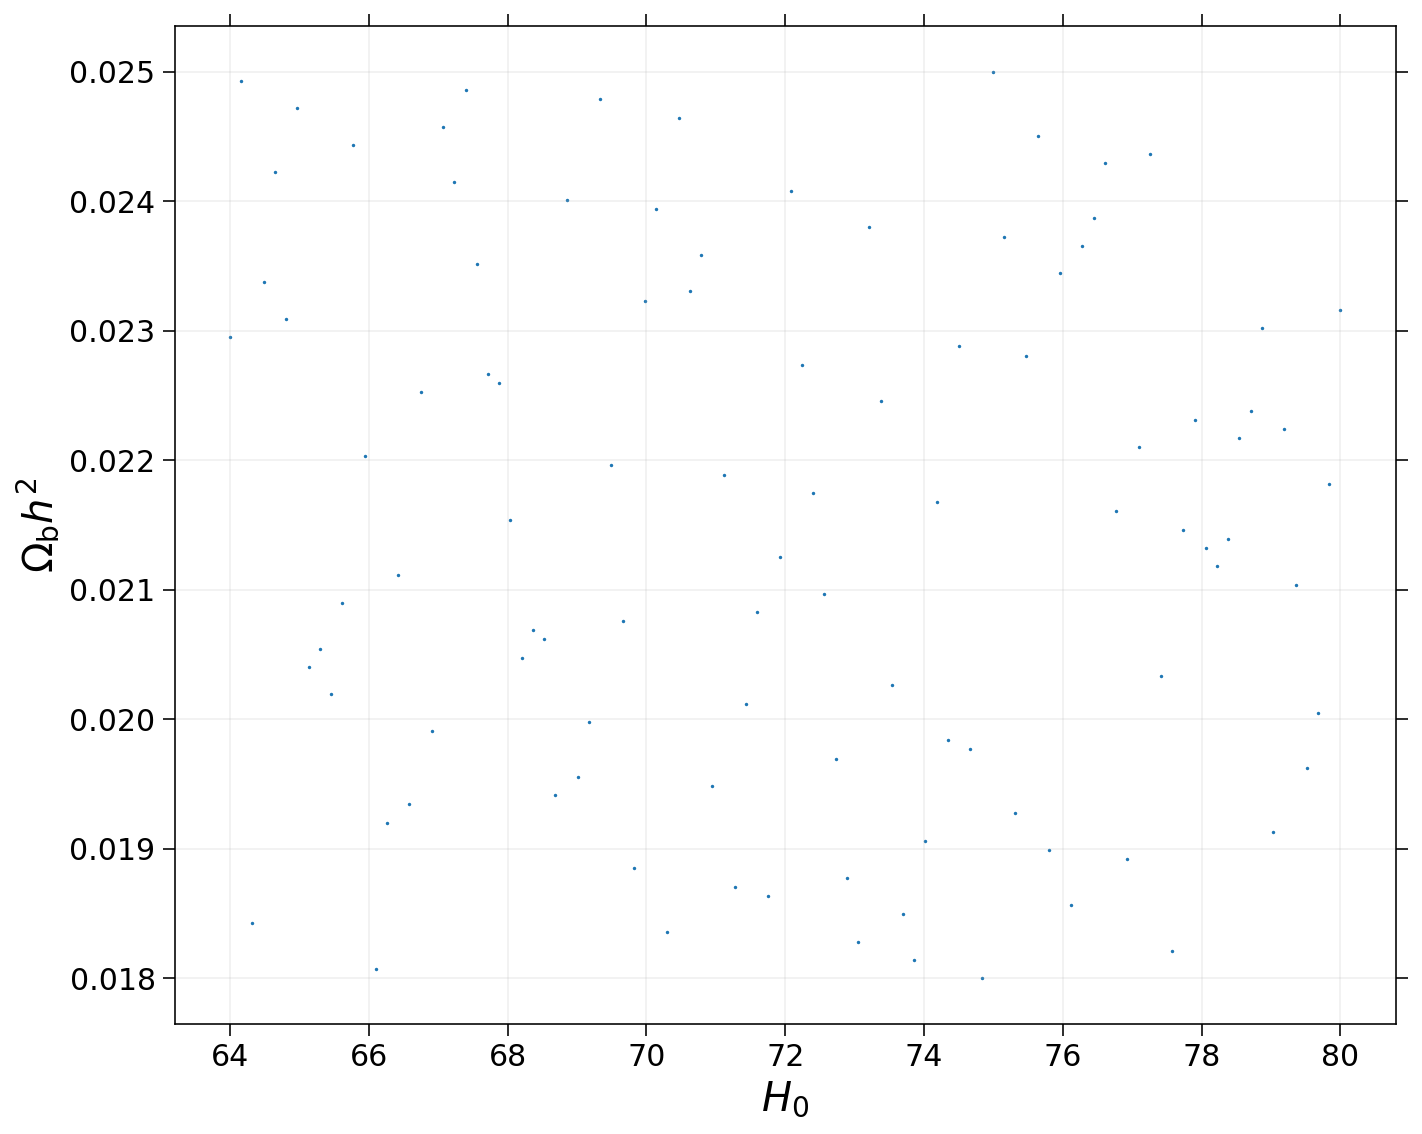

In [13]:
plt.figure(figsize = (10,8))
plt.scatter(input_data['H0'], input_data['Omega_b'], s=0.5)
plt.xlabel(r'$H_{0}$')
plt.ylabel(r'$\Omega_{\mathrm{b}}h^{2}$')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.savefig('LHS_2dim.jpg')
plt.tight_layout()

In [14]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

# Storing the fit object for later reference
scaled_input = train_input_data.fit(input_data.values)              # Compute the mean and std to be used for later scaling

scaled_output = test_output_data.fit(output_data.values)
scaled_output_nonlin = test_output_data.fit(output_data_nonlin.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                              # Perform standardisation by centring and scaling    
y = scaled_output.transform(output_data.values)     
y_nonlin = scaled_output_nonlin.transform(output_data_nonlin.values)
#print(X)

-1.7148160424389407 3.7337231524410353


(array([[10., 10., 10., 10., 10., 10., 10., 10., 10., 10.],
        [10., 10., 10., 10., 10., 10., 10., 10., 10., 10.],
        [10., 10., 10., 10., 10., 10., 10., 10., 10., 10.]]),
 array([-1.71481604e+00, -1.37185283e+00, -1.02888963e+00, -6.85926417e-01,
        -3.42963208e-01, -8.88178420e-16,  3.42963208e-01,  6.85926417e-01,
         1.02888963e+00,  1.37185283e+00,  1.71481604e+00]),
 <a list of 3 BarContainer objects>)

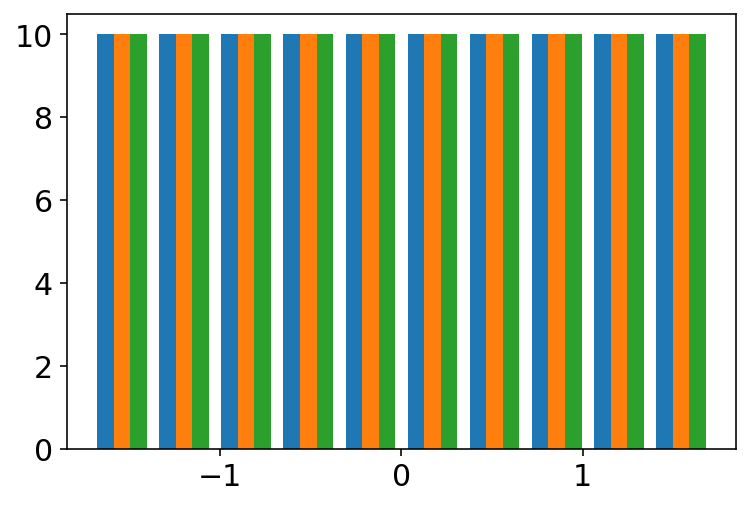

In [15]:
print(X.min(), y.max())
plt.hist(X)

In [16]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))   
print(X_train.shape[1]) 


X_train_nonlin, X_test_nonlin, y_train_nonlin, y_test_nonlin = train_test_split(X, y_nonlin, test_size=0.2, random_state=42)
print(np.shape(X_train_nonlin))
print(X_train.shape[1])    

(80, 3)
3
(80, 3)
3


In [17]:
#print(X_train)

In [18]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test samples, pts:",np.shape(X_test))

print("y_test_nonlin samples, pts:", np.shape(y_test_nonlin))
print("y_train_nonlin samples, pts:", np.shape(y_train_nonlin))
print("X_train_nonlin samples, pts:", np.shape(X_train_nonlin))
print("X_test_nonlin samples, pts:",np.shape(X_test_nonlin))
#print("X_train:", X_train)
#print("X_test:", X_test)

y_test samples, pts: (20, 500)
y_train samples, pts: (80, 500)
X_train samples, pts: (80, 3)
X_test samples, pts: (20, 3)
y_test_nonlin samples, pts: (20, 500)
y_train_nonlin samples, pts: (80, 500)
X_train_nonlin samples, pts: (80, 3)
X_test_nonlin samples, pts: (20, 3)


In [19]:
%%time
#Building the NN:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 2, epochs = 500, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model.summary()

Epoch 1/500
32/32 [==============================] - 1s 7ms/step - loss: 8.8051 - accuracy: 0.0000e+00 - val_loss: 9.2363 - val_accuracy: 0.0000e+00
Epoch 2/500
32/32 [==============================] - 0s 4ms/step - loss: 8.6265 - accuracy: 0.0000e+00 - val_loss: 8.8872 - val_accuracy: 0.0000e+00
Epoch 3/500
32/32 [==============================] - 0s 4ms/step - loss: 7.9642 - accuracy: 0.0000e+00 - val_loss: 7.6133 - val_accuracy: 0.0000e+00
Epoch 4/500
32/32 [==============================] - 0s 3ms/step - loss: 5.9414 - accuracy: 0.0000e+00 - val_loss: 4.5425 - val_accuracy: 0.0000e+00
Epoch 5/500
32/32 [==============================] - 0s 3ms/step - loss: 2.7551 - accuracy: 0.0156 - val_loss: 1.6327 - val_accuracy: 0.0000e+00
Epoch 6/500
32/32 [==============================] - 0s 3ms/step - loss: 1.2889 - accuracy: 0.0000e+00 - val_loss: 1.0643 - val_accuracy: 0.0000e+00
Epoch 7/500
32/32 [==============================] - 0s 3ms/step - loss: 0.9766 - accuracy: 0.0000e+00 - val_l

Epoch 58/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1522 - accuracy: 0.0625 - val_loss: 0.2783 - val_accuracy: 0.1250
Epoch 59/500
32/32 [==============================] - 0s 4ms/step - loss: 0.1430 - accuracy: 0.0625 - val_loss: 0.2897 - val_accuracy: 0.0625
Epoch 60/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1465 - accuracy: 0.0469 - val_loss: 0.2903 - val_accuracy: 0.0625
Epoch 61/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1381 - accuracy: 0.0625 - val_loss: 0.2743 - val_accuracy: 0.1250
Epoch 62/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1364 - accuracy: 0.0625 - val_loss: 0.2702 - val_accuracy: 0.0625
Epoch 63/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1365 - accuracy: 0.0469 - val_loss: 0.2670 - val_accuracy: 0.0625
Epoch 64/500
32/32 [==============================] - 0s 3ms/step - loss: 0.1307 - accuracy: 0.0625 - val_loss: 0.2720 - val_accuracy: 0.0625
Epoch 

32/32 [==============================] - 0s 4ms/step - loss: 0.0453 - accuracy: 0.0625 - val_loss: 0.1259 - val_accuracy: 0.1250
Epoch 116/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0443 - accuracy: 0.0625 - val_loss: 0.1395 - val_accuracy: 0.0000e+00
Epoch 117/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0457 - accuracy: 0.0625 - val_loss: 0.1168 - val_accuracy: 0.1250
Epoch 118/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0426 - accuracy: 0.0625 - val_loss: 0.1198 - val_accuracy: 0.1250
Epoch 119/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0424 - accuracy: 0.0781 - val_loss: 0.1145 - val_accuracy: 0.1250
Epoch 120/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0429 - accuracy: 0.0938 - val_loss: 0.1098 - val_accuracy: 0.1250
Epoch 121/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0406 - accuracy: 0.0625 - val_loss: 0.1106 - val_accuracy: 0.0625
Epoch 122

32/32 [==============================] - 0s 3ms/step - loss: 0.0221 - accuracy: 0.1250 - val_loss: 0.0679 - val_accuracy: 0.1875
Epoch 173/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0209 - accuracy: 0.1562 - val_loss: 0.0794 - val_accuracy: 0.2500
Epoch 174/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.1562 - val_loss: 0.0890 - val_accuracy: 0.1250
Epoch 175/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0204 - accuracy: 0.2031 - val_loss: 0.0729 - val_accuracy: 0.1875
Epoch 176/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0194 - accuracy: 0.1250 - val_loss: 0.0789 - val_accuracy: 0.2500
Epoch 177/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0191 - accuracy: 0.2031 - val_loss: 0.0882 - val_accuracy: 0.1250
Epoch 178/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0198 - accuracy: 0.1250 - val_loss: 0.0697 - val_accuracy: 0.2500
Epoch 179/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.1719 - val_loss: 0.0586 - val_accuracy: 0.2500
Epoch 230/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0129 - accuracy: 0.1406 - val_loss: 0.0663 - val_accuracy: 0.2500
Epoch 231/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0118 - accuracy: 0.1562 - val_loss: 0.0598 - val_accuracy: 0.1875
Epoch 232/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0113 - accuracy: 0.1719 - val_loss: 0.0558 - val_accuracy: 0.2500
Epoch 233/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0115 - accuracy: 0.1562 - val_loss: 0.0631 - val_accuracy: 0.1875
Epoch 234/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0105 - accuracy: 0.1562 - val_loss: 0.0657 - val_accuracy: 0.1250
Epoch 235/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0111 - accuracy: 0.1875 - val_loss: 0.0697 - val_accuracy: 0.2500
Epoch 236/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0079 - accuracy: 0.1875 - val_loss: 0.0581 - val_accuracy: 0.1875
Epoch 287/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0080 - accuracy: 0.1875 - val_loss: 0.0575 - val_accuracy: 0.1250
Epoch 288/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0074 - accuracy: 0.1875 - val_loss: 0.0581 - val_accuracy: 0.1250
Epoch 289/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 0.1562 - val_loss: 0.0565 - val_accuracy: 0.1875
Epoch 290/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0074 - accuracy: 0.1875 - val_loss: 0.0529 - val_accuracy: 0.1875
Epoch 291/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0085 - accuracy: 0.1875 - val_loss: 0.0516 - val_accuracy: 0.1250
Epoch 292/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0083 - accuracy: 0.1562 - val_loss: 0.0713 - val_accuracy: 0.1875
Epoch 293/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0069 - accuracy: 0.2188 - val_loss: 0.0425 - val_accuracy: 0.1875
Epoch 344/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 0.1875 - val_loss: 0.0452 - val_accuracy: 0.1875
Epoch 345/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0066 - accuracy: 0.1875 - val_loss: 0.0573 - val_accuracy: 0.3750
Epoch 346/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 0.2188 - val_loss: 0.0551 - val_accuracy: 0.1875
Epoch 347/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.1875 - val_loss: 0.0482 - val_accuracy: 0.1875
Epoch 348/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.2500 - val_loss: 0.0436 - val_accuracy: 0.1875
Epoch 349/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0061 - accuracy: 0.1875 - val_loss: 0.0520 - val_accuracy: 0.2500
Epoch 350/500

32/32 [==============================] - 0s 4ms/step - loss: 0.0047 - accuracy: 0.2188 - val_loss: 0.0420 - val_accuracy: 0.2500
Epoch 401/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0048 - accuracy: 0.2031 - val_loss: 0.0419 - val_accuracy: 0.2500
Epoch 402/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0046 - accuracy: 0.1875 - val_loss: 0.0411 - val_accuracy: 0.1875
Epoch 403/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 0.2188 - val_loss: 0.0455 - val_accuracy: 0.3750
Epoch 404/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0049 - accuracy: 0.2031 - val_loss: 0.0516 - val_accuracy: 0.2500
Epoch 405/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0051 - accuracy: 0.2344 - val_loss: 0.0507 - val_accuracy: 0.1875
Epoch 406/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0045 - accuracy: 0.2188 - val_loss: 0.0444 - val_accuracy: 0.3125
Epoch 407/500

32/32 [==============================] - 0s 4ms/step - loss: 0.0036 - accuracy: 0.1562 - val_loss: 0.0407 - val_accuracy: 0.2500
Epoch 458/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0037 - accuracy: 0.2031 - val_loss: 0.0417 - val_accuracy: 0.2500
Epoch 459/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0038 - accuracy: 0.2500 - val_loss: 0.0438 - val_accuracy: 0.1875
Epoch 460/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0036 - accuracy: 0.2344 - val_loss: 0.0413 - val_accuracy: 0.1875
Epoch 461/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0035 - accuracy: 0.2031 - val_loss: 0.0482 - val_accuracy: 0.1875
Epoch 462/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 0.2188 - val_loss: 0.0432 - val_accuracy: 0.1250
Epoch 463/500
32/32 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 0.2812 - val_loss: 0.0417 - val_accuracy: 0.2500
Epoch 464/500

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

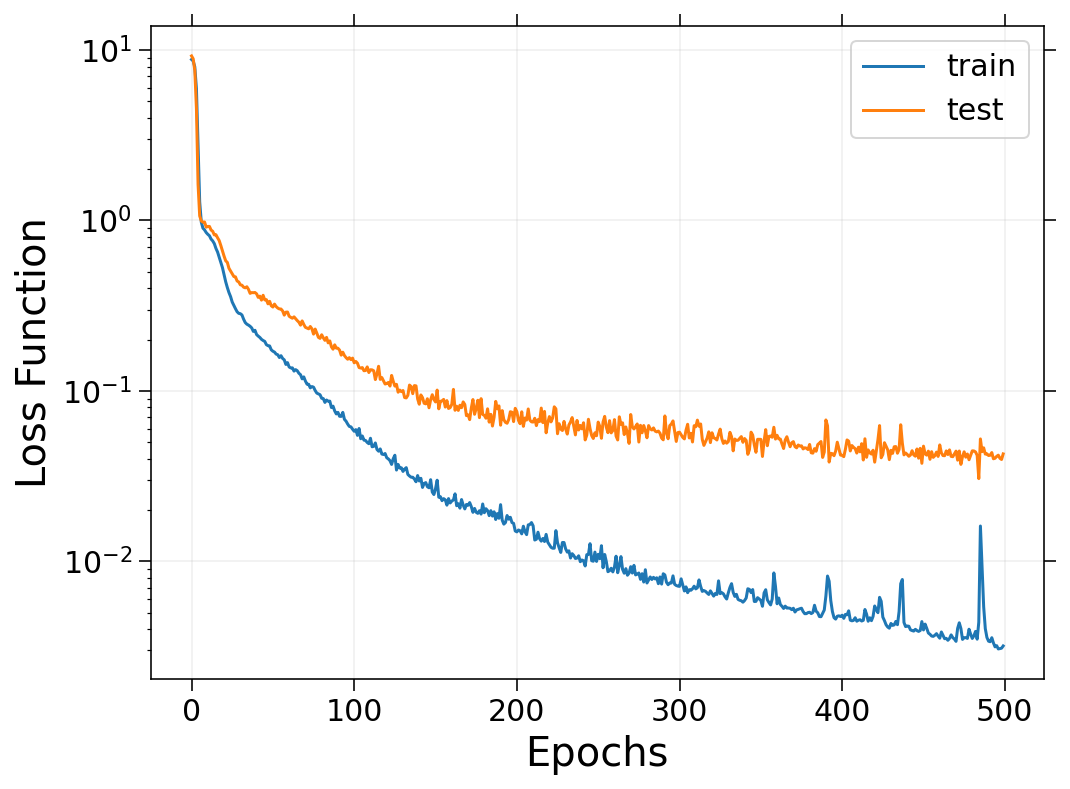

In [21]:
#Linear case:
plt.figure(figsize = (10,8))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
#plt.savefig('Loss_Func_H0.jpg')
plt.tight_layout

In [24]:
%%time
#Building the NN for NONLINEAR:

# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.01,
#                                   patience=30, min_lr=0.000000001)
# e_s = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100)

tf_model_nonlin = Sequential()
# Defining the input layer of the model
tf_model_nonlin.add(Dense(units=250, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu')) # 
 
# Defining 1st Hidden layer of the model
tf_model_nonlin.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining 2nd Hidden layer of the model
tf_model_nonlin.add(Dense(units=250, kernel_initializer='normal', activation='relu'))

# Defining the 3rd hidden layer of the model
#tf_model_nonlin.add(Dense(units=150, kernel_initializer='normal', activation='relu'))  

# Defining the 4th hidden layer of the model
#tf_model_nonlin.add(Dense(units=150, kernel_initializer='normal', activation='relu')) 

#Defining the output layer of the model
tf_model_nonlin.add(Dense(500, kernel_initializer='normal'))
 
# opt = keras.optimizers.Adam(learning_rate=1e-4)
#opt = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)  
    
# Compiling the model
tf_model_nonlin.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_nonlin = tf_model_nonlin.fit(X_train_nonlin, y_train_nonlin, batch_size = 2, epochs = 500, validation_split=0.2, verbose=1) # callbacks=[reduce_lr, e_s],
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test_nonlin - tf_model_nonlin.predict(X_test_nonlin))/y_test_nonlin))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#99.44523163935358, l_rate = 1e-4, 250 epochs, batch size = 50, 0.9837
#99.59918915882399, l_rate = 1e-4, 250 epochs, batch size = 20, 0.9934
tf_model_nonlin.summary()

Epoch 1/500
32/32 [==============================] - 0s 6ms/step - loss: 0.9547 - accuracy: 0.0000e+00 - val_loss: 1.1868 - val_accuracy: 0.0000e+00
Epoch 2/500
32/32 [==============================] - 0s 4ms/step - loss: 0.6588 - accuracy: 0.0000e+00 - val_loss: 0.6932 - val_accuracy: 0.0625
Epoch 3/500
32/32 [==============================] - 0s 4ms/step - loss: 0.3496 - accuracy: 0.0156 - val_loss: 0.4344 - val_accuracy: 0.0000e+00
Epoch 4/500
32/32 [==============================] - 0s 4ms/step - loss: 0.2492 - accuracy: 0.0000e+00 - val_loss: 0.4296 - val_accuracy: 0.0000e+00
Epoch 5/500
32/32 [==============================] - 0s 4ms/step - loss: 0.1943 - accuracy: 0.0000e+00 - val_loss: 0.3499 - val_accuracy: 0.0000e+00
Epoch 6/500
32/32 [==============================] - 0s 4ms/step - loss: 0.1621 - accuracy: 0.0000e+00 - val_loss: 0.3178 - val_accuracy: 0.0000e+00
Epoch 7/500
32/32 [==============================] - 0s 4ms/step - loss: 0.1496 - accuracy: 0.0156 - val_loss: 0.3

32/32 [==============================] - 0s 3ms/step - loss: 0.0343 - accuracy: 0.0781 - val_loss: 0.1361 - val_accuracy: 0.1250
Epoch 58/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0308 - accuracy: 0.0625 - val_loss: 0.1507 - val_accuracy: 0.0625
Epoch 59/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0340 - accuracy: 0.0781 - val_loss: 0.1264 - val_accuracy: 0.1250
Epoch 60/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0351 - accuracy: 0.0781 - val_loss: 0.1383 - val_accuracy: 0.1250
Epoch 61/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0329 - accuracy: 0.0938 - val_loss: 0.1299 - val_accuracy: 0.1250
Epoch 62/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0302 - accuracy: 0.0781 - val_loss: 0.1514 - val_accuracy: 0.0625
Epoch 63/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0286 - accuracy: 0.0938 - val_loss: 0.1352 - val_accuracy: 0.1250
Epoch 64/500
32/32 

32/32 [==============================] - 0s 3ms/step - loss: 0.0116 - accuracy: 0.1562 - val_loss: 0.1145 - val_accuracy: 0.1250
Epoch 115/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0096 - accuracy: 0.1406 - val_loss: 0.1048 - val_accuracy: 0.1250
Epoch 116/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0142 - accuracy: 0.1562 - val_loss: 0.1324 - val_accuracy: 0.1250
Epoch 117/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.1406 - val_loss: 0.1094 - val_accuracy: 0.0625
Epoch 118/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0095 - accuracy: 0.1719 - val_loss: 0.1067 - val_accuracy: 0.0625
Epoch 119/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0104 - accuracy: 0.1719 - val_loss: 0.1267 - val_accuracy: 0.1250
Epoch 120/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0103 - accuracy: 0.2031 - val_loss: 0.0941 - val_accuracy: 0.0625
Epoch 121/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0042 - accuracy: 0.1250 - val_loss: 0.1147 - val_accuracy: 0.2500
Epoch 172/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 0.1562 - val_loss: 0.1069 - val_accuracy: 0.1875
Epoch 173/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.1406 - val_loss: 0.1050 - val_accuracy: 0.1250
Epoch 174/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 0.1562 - val_loss: 0.0997 - val_accuracy: 0.1875
Epoch 175/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 0.1406 - val_loss: 0.1051 - val_accuracy: 0.1250
Epoch 176/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0044 - accuracy: 0.1406 - val_loss: 0.1087 - val_accuracy: 0.2500
Epoch 177/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 0.1406 - val_loss: 0.1044 - val_accuracy: 0.1875
Epoch 178/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.1406 - val_loss: 0.0988 - val_accuracy: 0.3125
Epoch 229/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.1250 - val_loss: 0.0905 - val_accuracy: 0.3125
Epoch 230/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0019 - accuracy: 0.1250 - val_loss: 0.1009 - val_accuracy: 0.3750
Epoch 231/500
32/32 [==============================] - 0s 4ms/step - loss: 0.0016 - accuracy: 0.1562 - val_loss: 0.0947 - val_accuracy: 0.3125
Epoch 232/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0016 - accuracy: 0.1406 - val_loss: 0.1001 - val_accuracy: 0.3125
Epoch 233/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.1250 - val_loss: 0.0929 - val_accuracy: 0.3125
Epoch 234/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0026 - accuracy: 0.1406 - val_loss: 0.1072 - val_accuracy: 0.3750
Epoch 235/500

32/32 [==============================] - 0s 3ms/step - loss: 0.0032 - accuracy: 0.1094 - val_loss: 0.1015 - val_accuracy: 0.3750
Epoch 286/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0050 - accuracy: 0.1562 - val_loss: 0.1070 - val_accuracy: 0.3750
Epoch 287/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0128 - accuracy: 0.1406 - val_loss: 0.1713 - val_accuracy: 0.4375
Epoch 288/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0088 - accuracy: 0.1562 - val_loss: 0.1040 - val_accuracy: 0.3125
Epoch 289/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 0.1562 - val_loss: 0.1155 - val_accuracy: 0.4375
Epoch 290/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.1406 - val_loss: 0.0989 - val_accuracy: 0.3125
Epoch 291/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.1406 - val_loss: 0.1031 - val_accuracy: 0.3125
Epoch 292/500

32/32 [==============================] - 0s 4ms/step - loss: 7.2827e-04 - accuracy: 0.1406 - val_loss: 0.1039 - val_accuracy: 0.4375
Epoch 342/500
32/32 [==============================] - 0s 3ms/step - loss: 7.6220e-04 - accuracy: 0.2031 - val_loss: 0.1100 - val_accuracy: 0.4375
Epoch 343/500
32/32 [==============================] - 0s 3ms/step - loss: 8.0571e-04 - accuracy: 0.2031 - val_loss: 0.1041 - val_accuracy: 0.4375
Epoch 344/500
32/32 [==============================] - 0s 3ms/step - loss: 8.0844e-04 - accuracy: 0.1719 - val_loss: 0.1040 - val_accuracy: 0.3750
Epoch 345/500
32/32 [==============================] - 0s 3ms/step - loss: 9.7804e-04 - accuracy: 0.1250 - val_loss: 0.1027 - val_accuracy: 0.4375
Epoch 346/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.1875 - val_loss: 0.1209 - val_accuracy: 0.4375
Epoch 347/500
32/32 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 0.2188 - val_loss: 0.0801 - val_accuracy: 

32/32 [==============================] - 0s 3ms/step - loss: 5.5758e-04 - accuracy: 0.1719 - val_loss: 0.0977 - val_accuracy: 0.3750
Epoch 398/500
32/32 [==============================] - 0s 3ms/step - loss: 4.8670e-04 - accuracy: 0.1406 - val_loss: 0.1004 - val_accuracy: 0.4375
Epoch 399/500
32/32 [==============================] - 0s 3ms/step - loss: 4.8665e-04 - accuracy: 0.1406 - val_loss: 0.1022 - val_accuracy: 0.4375
Epoch 400/500
32/32 [==============================] - 0s 3ms/step - loss: 4.5937e-04 - accuracy: 0.1562 - val_loss: 0.1014 - val_accuracy: 0.3750
Epoch 401/500
32/32 [==============================] - 0s 3ms/step - loss: 4.6163e-04 - accuracy: 0.1562 - val_loss: 0.1019 - val_accuracy: 0.5000
Epoch 402/500
32/32 [==============================] - 0s 3ms/step - loss: 4.6835e-04 - accuracy: 0.1719 - val_loss: 0.1011 - val_accuracy: 0.4375
Epoch 403/500
32/32 [==============================] - 0s 3ms/step - loss: 4.5137e-04 - accuracy: 0.1562 - val_loss: 0.1017 - val_ac

32/32 [==============================] - 0s 4ms/step - loss: 3.3118e-04 - accuracy: 0.1719 - val_loss: 0.1046 - val_accuracy: 0.5000
Epoch 454/500
32/32 [==============================] - 0s 4ms/step - loss: 3.2987e-04 - accuracy: 0.2188 - val_loss: 0.1046 - val_accuracy: 0.4375
Epoch 455/500
32/32 [==============================] - 0s 4ms/step - loss: 3.3472e-04 - accuracy: 0.2500 - val_loss: 0.1030 - val_accuracy: 0.5625
Epoch 456/500
32/32 [==============================] - 0s 4ms/step - loss: 3.2459e-04 - accuracy: 0.1719 - val_loss: 0.1041 - val_accuracy: 0.5000
Epoch 457/500
32/32 [==============================] - 0s 4ms/step - loss: 3.2279e-04 - accuracy: 0.1719 - val_loss: 0.1026 - val_accuracy: 0.5625
Epoch 458/500
32/32 [==============================] - 0s 4ms/step - loss: 3.2007e-04 - accuracy: 0.2656 - val_loss: 0.1042 - val_accuracy: 0.5625
Epoch 459/500
32/32 [==============================] - 0s 4ms/step - loss: 3.1814e-04 - accuracy: 0.2031 - val_loss: 0.1048 - val_ac

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

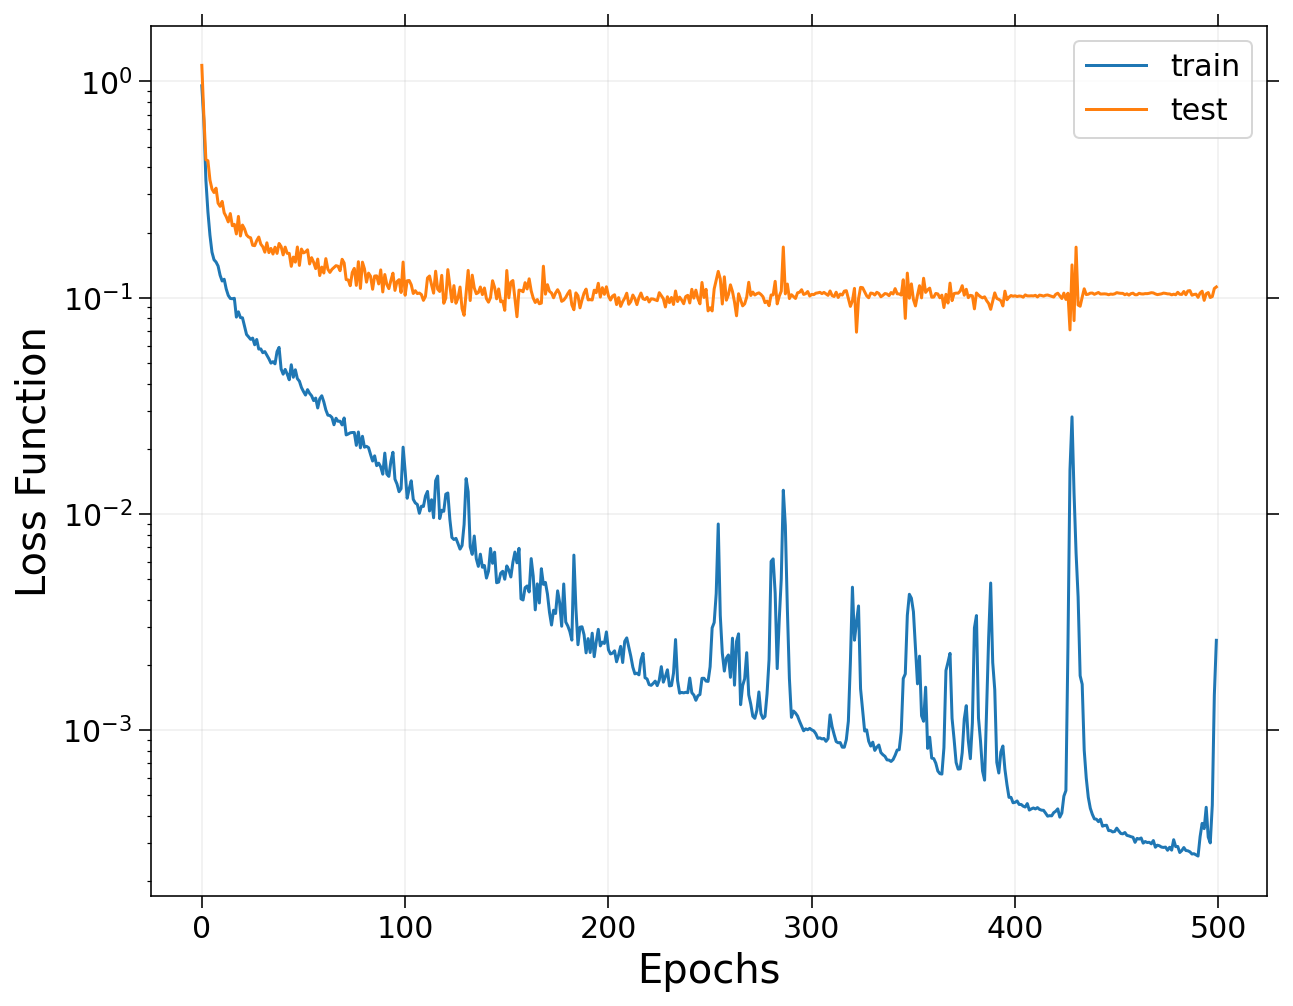

In [25]:
plt.figure(figsize = (10,8))
plt.plot(hist_nonlin.history["loss"], label="train")
plt.plot(hist_nonlin.history["val_loss"], label="test")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
#plt.savefig('Loss_Func_H0.jpg')
plt.tight_layout

In [26]:
X_train.shape[1]

3

H0: 64.0 - 80.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250 78 0.02 0.119


parameter:  ['78', '0.02', '0.119']
user_list: [78.0, 0.02, 0.119]
cosmo_arr [[7.80e+01 2.00e-02 1.19e-01]]
cosmo_arr[0] [7.80e+01 2.00e-02 1.19e-01]
input_scaled [[ 1.28611203 -0.73492116 -0.53159297]]
H0: 78.0 Omega_b: 0.02 Omega_c: 0.119


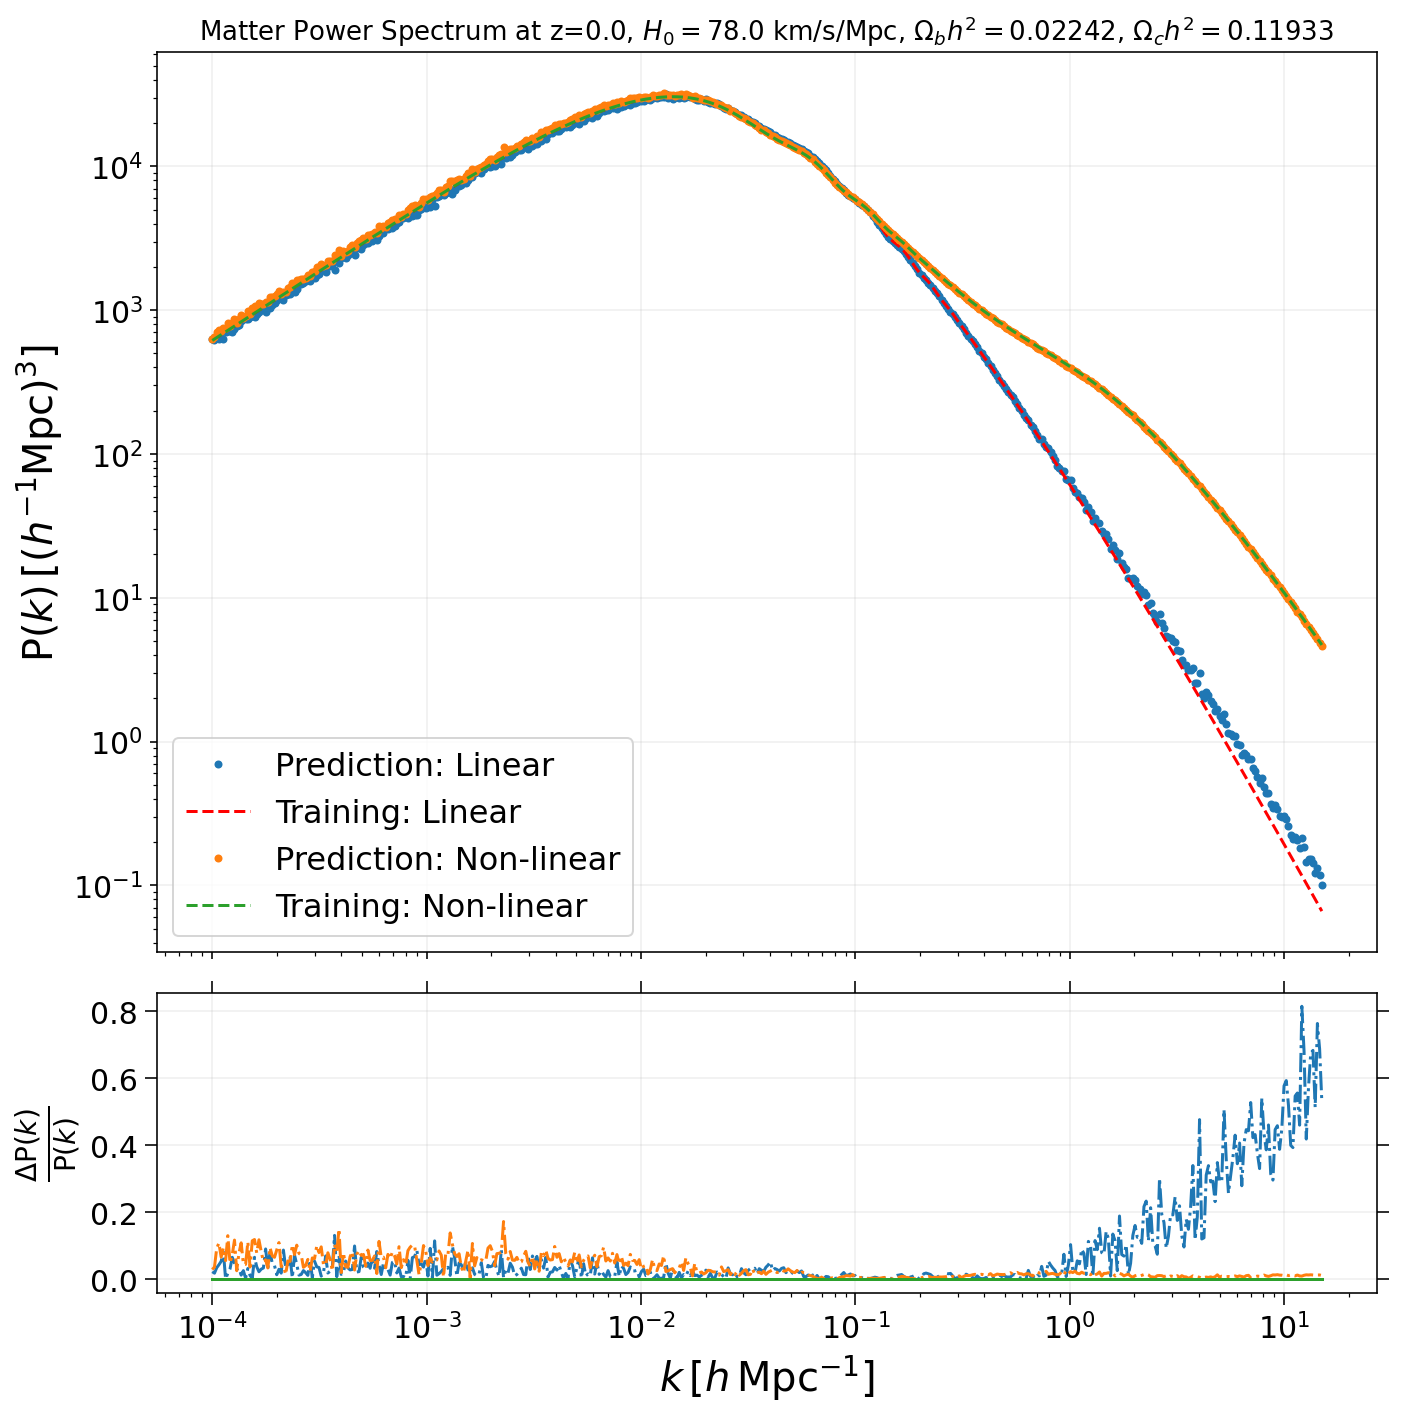

In [27]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 64.0 - 80.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250 ')
    print("\n")
    user_list = input_cosmo_val.split()
    # print list
    print('parameter: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data.values)
    input_scaled = scaled.transform(cosmo_arr)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))
    pred_pk_nonlin = scaled_output.inverse_transform(tf_model_nonlin.predict([input_scaled]))
    #Return to log scale for pred:
    #pred_pk = np.exp(pred_rescaled_pk)
    
    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur

    # Non-Linear spectra (Halofit)
    pars.NonLinear = model.NonLinear_both
    results.calc_power_spectra(pars)
    camb_kh_nonlin, z_nonlin, camb_pk_nonlin_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints = 500)
    camb_pk_nonlin = renorm_s8*camb_pk_nonlin_cur

    print('H0:' , cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (10,10), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                                                               
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashed')     
    ax[0].loglog(camb_kh, pred_pk_nonlin[0], "C1.")
    ax[0].loglog(camb_kh, camb_pk_nonlin[0], 'C2', linestyle='dashed') 
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} = %0.5s \ \mathregular{km/s/Mpc}$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = 0.02242$, ' + '$\Omega_{c}h^{2} = 0.11933$ ', fontsize = 13)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction: Linear', 'Training: Linear', 'Prediction: Non-linear', 'Training: Non-linear'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].plot(camb_kh, np.abs((pred_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C1', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk_nonlin[0]-camb_pk_nonlin[0])/camb_pk_nonlin[0]), 'C2')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.05)
    fig.tight_layout()
    #plt.savefig('NN_MPS_H0.jpg')
    plt.show()
    

Generate = calc_cosmo()